In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [5]:
cd /content/drive/MyDrive/comma_ai_dev/Probono-AI-Model/preprocessed_data

/content/drive/MyDrive/comma_ai_dev/Probono-AI-Model/preprocessed_data


In [6]:
df = pd.read_csv('Yeokchon_pop_data.csv', index_col='Datetime', parse_dates=True)

In [7]:
df.describe()

,population
count,8760.000000
mean,40849.784788
std,4368.034713
min,30295.306600
25%,37175.147425
50%,42476.629600
75%,44532.671975
max,46538.972500


In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [9]:
len_month = 744 #한달치 데이터 길이
len_week = 168 #일주일치 데이터 길이
len_day = 24 #하루치 데이터 길이

In [10]:
len(df)

8760

In [11]:
train = df.iloc[:-len_month]  #test 데이터셋:8016
test = df.iloc[-len_month:] #train 데이터셋: 744 (한달치 data)

In [16]:
 #데이터 scaling
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
pd.DataFrame(scaled_train, index = train.index, columns=train.columns).head(48)

,population
Datetime,
2022-09-01 00:00:00,0.904534
2022-09-01 01:00:00,0.927829
2022-09-01 02:00:00,0.914406
2022-09-01 03:00:00,0.920996
2022-09-01 04:00:00,0.926579
2022-09-01 05:00:00,0.875752
2022-09-01 06:00:00,0.794558
2022-09-01 07:00:00,0.652045
2022-09-01 08:00:00,0.357678


In [20]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [21]:
scaled_train = scaled_train.reshape(-1)
scaled_test = scaled_test.reshape(-1)
print(scaled_train.shape)
print(scaled_test.shape)

(8016,)
(744,)


In [22]:
n_steps = len_day #일주일치 데이터
n_features = 1  #단변량 데이터

x_train, y_train = split_sequence(scaled_train, n_steps) #x_train = (7848,168), y_train = (7848,1)
x_test, y_test = split_sequence(scaled_test, n_steps) #x_test = (576,168), y_test = (576,1)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

7992 7992
720 720


In [23]:
pd.DataFrame(x_train.T,
             index = [f'day{x+1}' for x in range(x_train.shape[1])],
             columns = [f'input_{x+1}' for x in range(x_train.shape[0])])

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,...,input_7983,input_7984,input_7985,input_7986,input_7987,input_7988,input_7989,input_7990,input_7991,input_7992
day1,0.904534,0.927829,0.914406,0.920996,0.926579,0.875752,0.794558,0.652045,0.357678,0.227565,...,0.583178,0.590305,0.619353,0.668778,0.690049,0.749879,0.777324,0.783267,0.791121,0.805037
day2,0.927829,0.914406,0.920996,0.926579,0.875752,0.794558,0.652045,0.357678,0.227565,0.186468,...,0.590305,0.619353,0.668778,0.690049,0.749879,0.777324,0.783267,0.791121,0.805037,0.827586
day3,0.914406,0.920996,0.926579,0.875752,0.794558,0.652045,0.357678,0.227565,0.186468,0.171584,...,0.619353,0.668778,0.690049,0.749879,0.777324,0.783267,0.791121,0.805037,0.827586,0.850319
day4,0.920996,0.926579,0.875752,0.794558,0.652045,0.357678,0.227565,0.186468,0.171584,0.169815,...,0.668778,0.690049,0.749879,0.777324,0.783267,0.791121,0.805037,0.827586,0.850319,0.848701
day5,0.926579,0.875752,0.794558,0.652045,0.357678,0.227565,0.186468,0.171584,0.169815,0.134793,...,0.690049,0.749879,0.777324,0.783267,0.791121,0.805037,0.827586,0.850319,0.848701,0.862560
day6,0.875752,0.794558,0.652045,0.357678,0.227565,0.186468,0.171584,0.169815,0.134793,0.160851,...,0.749879,0.777324,0.783267,0.791121,0.805037,0.827586,0.850319,0.848701,0.862560,0.859094
day7,0.794558,0.652045,0.357678,0.227565,0.186468,0.171584,0.169815,0.134793,0.160851,0.215552,...,0.777324,0.783267,0.791121,0.805037,0.827586,0.850319,0.848701,0.862560,0.859094,0.808852
day8,0.652045,0.357678,0.227565,0.186468,0.171584,0.169815,0.134793,0.160851,0.215552,0.343975,...,0.783267,0.791121,0.805037,0.827586,0.850319,0.848701,0.862560,0.859094,0.808852,0.736254
day9,0.357678,0.227565,0.186468,0.171584,0.169815,0.134793,0.160851,0.215552,0.343975,0.412249,...,0.791121,0.805037,0.827586,0.850319,0.848701,0.862560,0.859094,0.808852,0.736254,0.614584
day10,0.227565,0.186468,0.171584,0.169815,0.134793,0.160851,0.215552,0.343975,0.412249,0.544660,...,0.805037,0.827586,0.850319,0.848701,0.862560,0.859094,0.808852,0.736254,0.614584,0.467069


In [24]:
pd.DataFrame(y_train.T,
             index = [f'output_{x+1}' for x in range(y_train.shape[0])],
             columns = [f'day1'])

,day1
output_1,0.897797
output_2,0.925316
output_3,0.937999
output_4,0.927593
output_5,0.931629
...,...
output_7988,0.641378
output_7989,0.749564
output_7990,0.785773
output_7991,0.824663


In [25]:
model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps,n_features))) #first layer
model.add(Dropout(0.5))

model.add(LSTM(units = 64)) #second layer
model.add(Dropout(0.5))

model.add(Dense(1)) #output layer

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
#모델의 val_loss가 10epoch 동안 동일하면 학습을 중단

history = model.fit(x_train, y_train, epochs=30, callbacks=[early_stopping])

Epoch 1/30
250/250 [==============================] - 22s 52ms/step - loss: 0.0500 - mae: 0.1728
Epoch 2/30
250/250 [==============================] - 13s 51ms/step - loss: 0.0200 - mae: 0.1111
Epoch 3/30
250/250 [==============================] - 13s 51ms/step - loss: 0.0165 - mae: 0.1004
Epoch 4/30
250/250 [==============================] - 12s 47ms/step - loss: 0.0133 - mae: 0.0907
Epoch 5/30
250/250 [==============================] - 12s 47ms/step - loss: 0.0123 - mae: 0.0866
Epoch 6/30
250/250 [==============================] - 13s 53ms/step - loss: 0.0104 - mae: 0.0793
Epoch 7/30
250/250 [==============================] - 13s 51ms/step - loss: 0.0094 - mae: 0.0752
Epoch 8/30
250/250 [==============================] - 13s 51ms/step - loss: 0.0084 - mae: 0.0712
Epoch 9/30
250/250 [==============================] - 13s 51ms/step - loss: 0.0080 - mae: 0.0692
Epoch 10/30
250/250 [==============================] - 13s 51ms/step - loss: 0.0071 - mae: 0.0651
Epoch 11/30
250/250 [========

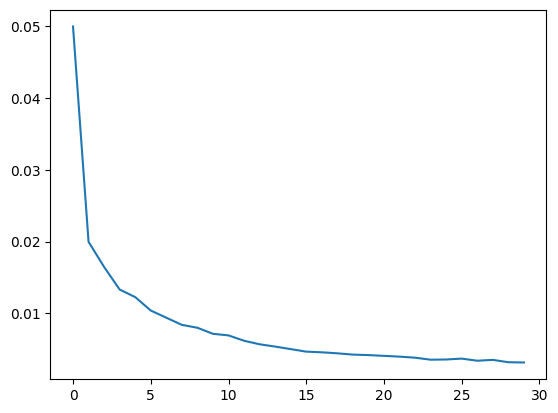

In [28]:
import matplotlib.pyplot as plt
myloss = model.history.history['loss']
plt.plot(range(len(myloss)), model.history.history['loss'])

In [29]:
import math
from sklearn.metrics import mean_squared_error

In [30]:
# tratrainPredict = scaler.inverse_transform(trainPredict)
#train값과 test값 예측
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

# 역정규화 과정
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

# rmse 계산
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

23/23 [==============================] - 0s 6ms/step
Train Score: 596.24 RMSE
Test Score: 683.59 RMSE


<Axes: xlabel='Datetime'>

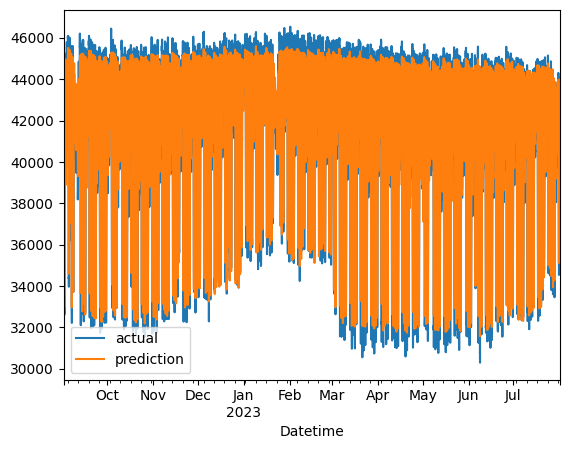

In [31]:
val_train  = pd.DataFrame() #예측값 검증을 위한 df 생성

trainPredict = pd.DataFrame(trainPredict)
trainPredict.index = train[-len(trainPredict):].index #실제 test 범위에 해당하는 index 매칭

val_train['actual'] = train[-len(trainPredict):] #실제 값 할당
val_train['prediction'] = trainPredict #예측한 값 할당

val_train.plot()

In [32]:
len(val_train)

7992

<Axes: xlabel='Datetime'>

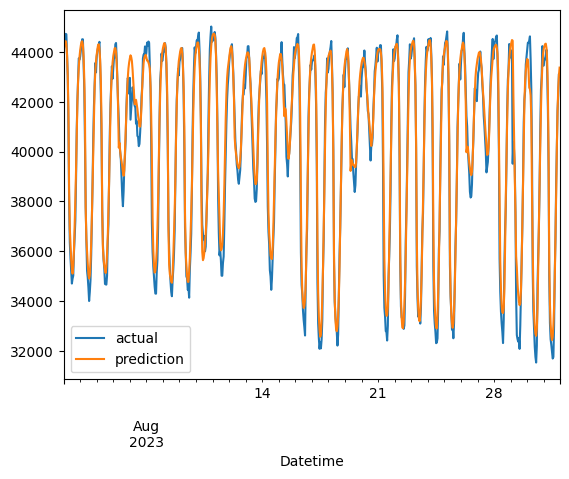

In [33]:
val_test = pd.DataFrame() #예측값 검증을 위한 df 생성

testPredict = pd.DataFrame(testPredict)
testPredict.index = test[-len(testPredict):].index #실제 test 범위에 해당하는 index 매칭

val_test['actual'] = test[-len(testPredict):] #실제 값 할당
val_test['prediction'] = testPredict #예측한 값 할당

val_test.plot()

In [34]:
from keras.models import load_model
model.save("yeokchon_model.h5")